In [2]:
import ujson as json
import sys
import os
sys.path.append(os.path.join(sys.path[0], "../"))
import re
import argparse
import gzip
import shutil

import bootleg_data_prep.utils.data_prep_utils as prep_utils

from collections import defaultdict

In [16]:
root_dir = '/dfs/scratch1/mleszczy/bootleg-internal'

In [45]:
def get_title_to_wpid(args):
    oldtitle2wpid = {}
    with open(args.redirect_map) as in_file:
        # line looks like this:
        # http://en.wikipedia.org/wiki/Mike_Conley,_Sr.	Mike Conley Sr.
        for line in in_file:
            old_title, wpid = line.strip().split("\t")
            oldtitle2wpid[old_title] = wpid
    print(f"Loaded {len(oldtitle2wpid)} title redirect pairs from {args.redirect_map}")
    return oldtitle2wpid


class QIDMapper:

    def __init__(self, wpid2qid, title2qid, redirect_title2wpid):

        self.wpid2qid = wpid2qid # maps wpid to QID
        self.title2qid = title2qid # maps wikipedia page title to QID
        self.redirect_title2wpid = redirect_title2wpid # maps [old] wikipedia page title to WPID (frequently result of redirect)



    def get_qid(self, title, wpid):

        # Get QID based on title
        if title in self.title2qid:
            return self.title2qid[title]

        # Get redirected title
        if title in self.redirect_title2wpid:
            wpid = self.redirect_title2wpid[title]
            if wpid in self.wpid2qid:
                return self.wpid2qid[title]

        # Get based on WPID
        if wpid in self.wpid2qid:
            return self.wpid2qid[wpid]

        return None


def remove_duplicates(cands): 
    new_cands = {}
    for cand, prior in cands: 
        if cand in new_cands: 
            # update prior if greater
            if prior > new_cands[cand]: 
                new_cands[cand] = prior
        else: 
            new_cands[cand] = prior
    return [[qid, prior] for qid, prior in new_cands.items()]

def process_files_pershina_uniq(qm, args):
    files = prep_utils.glob_files(os.path.join(args.data_dir, 'raw/*/*'))
    dropped_wpids = set()
    found_wpids = set() 
    alias_to_candidates = {}
    alias = None
    alias_mismatch = set()
    alias_name_map = {}
    doc_id = None
    for file in files:
        al_idx = 0 
        alias = None
        with open(file) as in_file:
            for line in in_file:
                items = line.strip().split("\t")
                if items[0] == 'ENTITY':
                    # get original alias text
                    assert 'origText' in items[7]
                    assert 'docId' in items[6]
                    if alias is not None: 
                        alias_to_candidates[alias] = filtered_candidates
                        al_idx += 1
                    doc_id = items[6].split('docId:')[1].lower() 
                    # alias candidates differ by document 
                    alias = f'alias_{doc_id}_{al_idx}'
                    alias_name = items[7].split('origText:')[1].lower()
                    alias_name_map[alias] = alias_name
                    filtered_candidates = set()
                    uniq_cands = set()
                    true_mention = items[8].split('url:')[1] != 'NIL'
                    if not true_mention: 
                        alias = None
                    
                elif items[0] == 'CANDIDATE':
                    # get candidates
                    title = items[6].split('name:')[1].lower()
                    wpid = items[1].split('id:')[1].lower()
                    count = int(items[2].split('inCount:')[1].lower())
                    qid = qm.get_qid(title, wpid)
                    if qid is None:
                        dropped_wpids.add(wpid)
                    else:
                        filtered_candidates.add((qid, count))
                        found_wpids.add(wpid) 
                        uniq_cands.add(qid)             

        if alias is not None:
            alias_to_candidates[alias] = filtered_candidates
    
    print('Dropped wpids\t', len(dropped_wpids))
    print('Found wpids\t', len(found_wpids))
    
    max_len = -1 
    for alias in alias_to_candidates:
        cands = [list(t) for t in alias_to_candidates[alias]]
        max_len = max(max_len, len(cands))
        # check for duplicates and take higher prior if duplicates occur 
        cands = remove_duplicates(cands)
        alias_to_candidates[alias] = sorted(cands, key=lambda x: (x[1], x[0]), reverse=True)[:args.topK]
    print(f"Loaded candidates for {len(alias_to_candidates)} aliases")
    print('Max number of cands\t', max_len)
    return alias_to_candidates, alias_name_map

In [19]:
args = argparse.Namespace(data_dir=f'{root_dir}/bootleg_data_prep/benchmarks/pershina/',
                         out_dir='processed', 
                         title_to_qid='/dfs/scratch1/mleszczy/contextual-embeddings-git/title_to_all_ids.jsonl', 
                         redirect_map=f'{root_dir}/bootleg_data_prep/benchmarks/aida/raw_aida/redirects_map.txt',
                         topK=30)

In [20]:
redirect_title2wpid = get_title_to_wpid(args)

Loaded 5598 title redirect pairs from /dfs/scratch1/mleszczy/bootleg-internal/bootleg_data_prep/benchmarks/aida/raw_aida/redirects_map.txt


In [21]:
title2qid, _, wpid2qid, _ = prep_utils.load_qid_title_map(args.title_to_qid)
qm = QIDMapper(wpid2qid, title2qid, redirect_title2wpid)

100%|██████████| 6457844/6457844 [01:04<00:00, 100623.72it/s]


Loaded title-qid map for 6385971 titles from /dfs/scratch1/mleszczy/contextual-embeddings-git/title_to_all_ids.jsonl. 64.18250966072083 seconds.


In [46]:
cands_pershina, alias_name_map = process_files_pershina_uniq(qm, args)

Dropped wpids	 923
Found wpids	 35622
Loaded candidates for 27816 aliases
Max number of cands	 50


In [47]:
# check for duplicates
seen_dup = 0
for alias, qids in cands_pershina.items():
    uniq_qids = set()
    for qid, _ in qids:
        if qid in uniq_qids:
            seen_dup += 1
            print(qid, alias)
            break
        uniq_qids.add(qid)
        if len(qids) == 0: 
            print('0 zero qids!', alias)
print(seen_dup)

0


In [48]:
# dump 
args.out_dir = 'processed'
out_dir = prep_utils.get_outdir(args.data_dir, args.out_dir)
with open(os.path.join(out_dir, 'cands.json'), 'w') as out_file:
    json.dump(cands_pershina, out_file)
    
with open(os.path.join(out_dir, 'vocab.json'), 'w') as out_file:
    json.dump(alias_name_map, out_file)

Making /dfs/scratch1/mleszczy/bootleg-internal/bootleg_data_prep/benchmarks/pershina/processed


In [42]:
# compute ambiguity of aida test after filtering
import jsonlines
import numpy as np 
count = 0.
cand_len_pershina = []
max_len = -1
num_greater_than_30 = 0 
num_equal_to_1 = 0 
with jsonlines.open('/dfs/scratch1/mleszczy/bootleg-internal/data/aida_docwiki_pershina/filtered/test.jsonl') as f: 
    for line in f: 
        for i, alias in enumerate(line['aliases']):
            if not line['anchor'][i]:
                continue
            if alias in cands_pershina: 
                count += 1
                max_len = max(len(cands_pershina[alias]), max_len)
                cand_len_pershina += [len(cands_pershina[alias])]
                num_greater_than_30 += len(cands_pershina[alias]) > 30
                num_equal_to_1 += len(cands_pershina[alias]) == 1
                
print(count, np.mean(cand_len_pershina), max_len,  num_greater_than_30, num_equal_to_1)

4470.0 11.974496644295302 30 0 1168


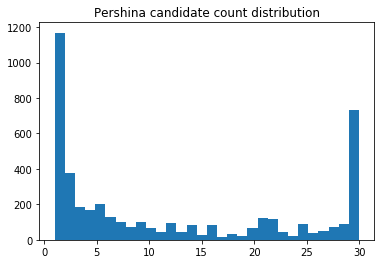

In [44]:
import matplotlib.pyplot as plt
plt.hist(cand_len_pershina, bins=30)
plt.title('Pershina candidate count distribution')
plt.savefig('pershina_cands.png', dpi=300)
plt.show() 